# "Create Your First PyTorch Model Using fastai"
> "We will create a model that will predict cattle breeds from an image."

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [fastai, pytorch, cattle]
<!-- - image: images/some_folder/your_image.png -->
- hide: false
- search_exclude: false
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

In [1]:
#hide
from fastbook import *
from fastai.vision.widgets import *

#hide
# !pip install voila
# !jupyter serverextension enable voila —sys-prefix

# Create Your First PyTorch Model

For those of you who don't know, my parents own a regenerative farm in Michigan. Regenerative farming is the  processing of using certain techiniques to inprove soil health, livestock health and in a sense create an envirnment closer to that of what nature allows to happen. One of the main products of the farm is rotational grazed grassfed beef cattle. Over the years the herd has grown in size. Starting with only about 10 animals to know around 50.

We've always named each cow and had a little back story to go with it. However, as the herd gets larger it becomes harder to remember all their names. So my idea is to create a "Cow name predictor" from and image I can upload off my phone. For example I snap a photo, upload to a basic file upload, click a button to classify, and voila! I recieve back the name of the cow and a predictive value or error.

Probably not the most useful application out there. Not like Cupcake (yes it's actually a name of one of our cows) is going to care if I get her name wrong.

If you would like to hear more about my family's farm, feel free to check out their website [Sugar Creek Farms](https://www.sugarcreek.co) 

## Tools we will use

I'll be using the following tools to get this started.
- Jupyter Notebook
- PyTorch
- fast.ai (& fastbook)
- voila
- Azure Search Key - used to request images from Bing
- That's it!

If you haven't used fastai yet, I would start immediately. It's a python package that abstracts away some of the boiler plate code of PyTorch. There are a lot of reasons why you should look into fast.ai but I'll keep it short and only list a couple really important points. The first is that fastai really is more a of model framework and approach to getting a PyTorch model setup. The tool itself sits on top of PyTorch, almost like Keras does for TensorFlow, and removes most of the boiler plate code that is necessary to get a PyTorch model up and running. The second point is that they have a lot of wonderful resources for getting started in AI and machine learning that you should check out.

## Considerations

While my task may be worthy my I may have underestimated how easy this would be. Some consideration have come to mind. How am I going to get images of all the individual cows? Secondly, will I even have enough to train a model on?

After looking through my Photos folder I've determined this is going to be really hard as I don't even have pictures for all the cows. You probably don't need as much data as you may think to train a model. It's suprising how much you can get out of a model with a realively small dataset. That being said I don't even have a 100 photos so my goal to predict a cows name isn't going to work today. I'll work on collecting that dataset to try again in the future :)

Instead I'll change the goal a little, keeping it in the same vein, and generate a model that prodicts the cows breed. I should have no issues getting enough data to do this. Here is what I'm thinking. I can create a Python list of breeds. I just Googled common cattle breeds and got `'black angus','charolais','hereford', 'simmental', 'red angus', 'texas longhorn', 'holstein', 'limousin', 'highlands'`. I can then loop through the images and use Bings Image Search API to request images of each.

## Setup

Open up Jupyter Notebooks, start a new notebook and install fastai and PyTorch which everway is easiest for you. I usually choose to use `pip`.

In [18]:
#hide
# !pip install -c fastai -c pytorch fastai
# !pip install -Uqq fastai torch

In [19]:
from fastbook import *
from fastai.vision.widgets import *

## Data Gathering

For this next bit you will have signup for a free Microsoft Azure account. Honestly, this will probably be the hardest part if you are following along and replicating `the cow name predicter`. Just do a quick Google search to find out how to sign up and you will find a lot of resources. Once you have successfully signed up for a free account, navigate to the Azure Search dashboard and grab your `AZURE_SEARCH_KEY` from the settings. You will need this to use the Azure/Bing image search API. Quick note on this service. It's free but limits you to 150 results per request and you can only request so many queries per second.

In [20]:
key = os.environ.get('AZURE_SEARCH_KEY', 'e729fecdbe1847019c17ca7728c8b2eb')

The above line will create a new environment variable containing your `AZURE_SEARCH_KEY`.

Once you've set `key`, you can use a handy function from fastbook `search_images_bing`. This is a really just a helper function to make an API request to the Azure image search API.

In [22]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128)>

TIP: You'll notice we didn't specifically import this function. We imported everything from `fastbook` using a wild import or `*`. This is usually a really bad idea; however, in this case we are fine to use. The reason this is a really bad ideas is that when python import `*` it imports everything. This even means that it import other imports--which really bloats your code. Another little tips--if you're not sure where something is coming from or don't know how to use it, you can `click` on that variable or function and hit `shift + tab` and this will bring a little information box about the function.

In [32]:
results = search_images_bing(key, 'angus cattle')
ims = results.attrgot('content_url')
len(ims)

150

As you can see from the output above, we've successfully downloaded 150 of angus cattle from Bing! We will take a look at one below. There are a ton of other ways to get data out there. This may not be the best way when you build your model so just do a quick Google search and see what's out there.

Below is an example of an image we grab just so you can see it. You can also sort through your directory and see there is now an `images` folder.

In [23]:
ims = ['https://www.sugarcreek.co/static/4d9f7e3fbf8300014a05b166f2729425/6a01c/00000img_00000_burst20200530212642818_cover.jpg']

In [24]:
dest = 'images/cattle.jpg'
download_url(ims[0], dest)

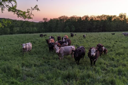

In [25]:
im = Image.open(dest)
im.to_thumb(128,128)

Okay, so know lets see if we can create a list of breeds and grab images for each! I'll also create a `path` variable.

In [27]:
cattle_types = 'black angus','charolais','hereford', 'simmental', 'red angus', 'texas longhorn', 'holstein', 'limousin', 'highlands'
path = Path('cattle')

In [48]:
if not path.exists():
    path.mkdir()
    for o in cattle_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} cattle')
        download_images(dest, urls=results.attrgot('content_url'))

The bit of code above is checking to see if there is a folder called `cattle`, if not then it is creating it and downloading search results for each one of the cattle breeds I listed above. Depending on your internet this should take a few minutes to run and download 150 images per cattle breed.

In [29]:
fns = get_image_files(path)
fns

(#1322) [Path('cattle/black angus/00000042.jpg'),Path('cattle/black angus/00000092.jpg'),Path('cattle/black angus/00000130.jpg'),Path('cattle/black angus/00000147.jpg'),Path('cattle/black angus/00000122.jpg'),Path('cattle/black angus/00000148.jpg'),Path('cattle/black angus/00000135.jpg'),Path('cattle/black angus/00000026.jpg'),Path('cattle/black angus/00000066.jpg'),Path('cattle/black angus/00000025.jpg')...]

Now that are verified photos have been download and save in `root_directory/cattle/[breed_name]` let's see if are any bad images. Almost always you will get some images that are not coded correctly or are not a images at all so it's best to just filter those out and throw them away.


Run the following and it will show which images are corrupt. You will see that we had 56 failed images. Take a look and see if you can't figure out why they failed. To remove failed images we can use the `unlink` method on `Path` which will make sure we don't try to send these failed images through our model.

In [32]:
failed = verify_images(fns)
failed

(#56) [Path('cattle/black angus/00000147.jpg'),Path('cattle/black angus/00000011.jpg'),Path('cattle/black angus/00000044.jpg'),Path('cattle/black angus/00000145.JPG'),Path('cattle/black angus/00000056.JPG'),Path('cattle/black angus/00000139.jpg'),Path('cattle/black angus/00000032.jpg'),Path('cattle/black angus/00000043.jpg'),Path('cattle/black angus/00000144.jpg'),Path('cattle/black angus/00000116.jpg')...]

In [33]:
failed.map(Path.unlink);  # Path.unlink removes the files from our Path object so that we won't use in our model.

## Preparing Training and Testing Datasets

In [34]:
cattle = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

The above code is running another useful function from fastai to take in data and return a training and testing datasets.

The first argument `blocks` takes in two variables, the intdependent variable (ImageBlock) and the dependent variable (CategoryBlock). Or often call features and labels. We train our model on features while labels are the correct answer. For instance if you're trying to predict someones salary, your features will be age, education, location, industry, etc. The label is the final choice, such as $65,000/yr.

Next we pass `git_image_files`, which is a list of path locations to the `git_items` argument. Basically just telling the dataloaders where all of our images are stored at.

`splitter` is used to randomly split that dataset up into training and testing dataset. It's extremely important to do this as early in the code as you can to make sure you are not accedentially training on testing data. `valid_pct` is a % of images you want to reserve for testing on. In this case we are reserving 20% of the data to test on. The remaining 80% will be used to train our model. `seed` is useful in telling the computer where to start the random number generater. It allows us to 'randomly' get the same results again and again.

`get_y` is used to set what are labels should be. fastai provides a function called `parent_label` which grabs the name of the parent directory the image in and sets it as the label or dependent variable.

Lastly, we have `item_tfms` or "item transforms" is reshaping all the images to be 128 by 128 pixels. We just need all the images to be the exact same dimentions if we are going to be using matrix multiplication or tensors.

In [35]:
dls = cattle.dataloaders(path)

Run the following to show and validate the data from the dataloaders.

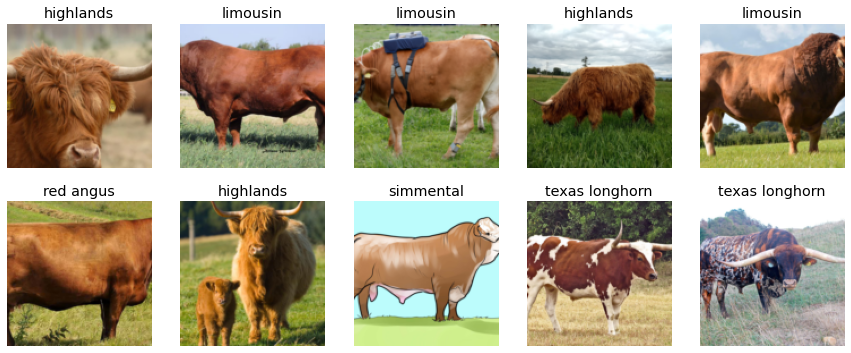

In [37]:
dls.valid.show_batch(max_n=10, nrows=2)

## Data Augmentation

To reformat all photos to be the same size of 128x128 pixels we can use several different options. We ahve the ability to squish or stretch them. This usually leads to phots of cows with very odd proportions not seen in nature. We can pad images. Think wide screen movie view with the black bars on top and bottom of the screen. This option does distort the photo at all; however, it does create a lot of empty image or space.

Usually the common practice is to select random crops of the photo and do this several times. This actually allows use to use an undistorted image multiple times increasing our dataset. See the code below and an example batch to see what I mean.

This process is refered to as data augmentation. There are a lot of common techniques you can use here from rotation, warping, flipping, contrast changes and brightness changes.

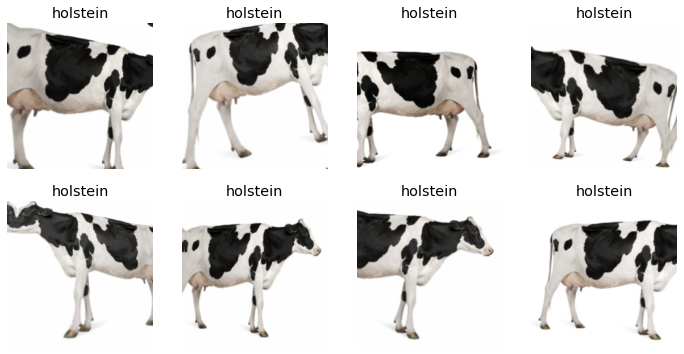

In [41]:
cattle = cattle.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = cattle.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model

Now that we have clean and preprocessed (split and augmented) our data we are ready to train our model!

In [42]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/user/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,2.620505,0.873106,0.284585,00:13


epoch,train_loss,valid_loss,error_rate,time
0,1.087951,0.742601,0.233202,00:12
1,0.934089,0.628281,0.189723,00:13
2,0.764373,0.587155,0.189723,00:13
3,0.651530,0.581575,0.185771,00:14


At first glance we didn't do that great. We have an error rate of 0.185771. Let's take a look at the confusion matrix to visualize the results and see where we can improve our model.

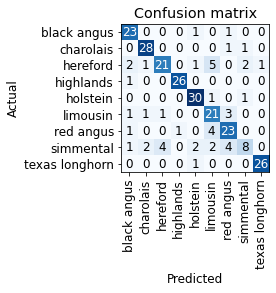

In [43]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The rows represent all the cattle breeds we have in our dataset. The columns represent the images the model predicted as one of the cattle breeds. This means the diagnal represents the number of images that were classified/predicted correctly while everthing else is was predicted wrong.

It can be really helpful to look and see where the errors are coming from. When I did this the first time I had only the breed 'angus' rather than 'black angus' and 'red angus'. By splitting these out the results have improved. We could do the exact some thing for 'herford' and 'simmental'. Both breeds often have but red and black colors. So by splitting these two up I would be willing to bet it would improve our model. Why don't you give it a try and see?

Because this is also a dataset that was gather online there could be images that are categorized wrong. There could also be this like hand drawn image or cartoons that are causing issues. It's always best to take a look at the images the model got wrong or was least confident about.

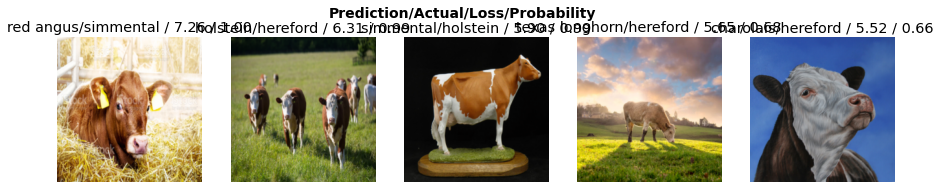

In [44]:
interp.plot_top_losses(5, nrows=1)

We can use fastai's ImageClassifierCleaner to create a GUI in Jupyter Notebook to actually clean up the data right here. Run the following line and you will can change or delete images to see how it effects your training and validation numbers.

In [45]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [46]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

We can see the simmental cattle breed has red and black cows. There are also three cartoons that can be delete.

Once you have clean up and reclassified your data you can remove the deleted files by running.
`for idx in cleaner.delete(): cleaner.fns[idx].unlink()`

And if you reclassified any of the breeds. Say from simmental to black angus you can run the following to move the image to the correct directory.
`for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)`

## What To Do Once You've Trained A Model?

So once you have trained your model how do you actually use it?

The fist thing we are going to do is save our model out using python's pickle package. Well kind of. fastai has build a useful function for exporting and loading models; however, they make use of pickle. We will be using that here. So first let's export our model as a pickle file to './export.pkl'

In [51]:
learn.export()

In [52]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

By running `.ls(file_exts='.pkl')` we can see our model has been saved out as `export.pkl`.

To load a model is just as easy. Run the following line to see.

In [53]:
learn_inf = load_learner(path/'export.pkl')

Now to see if the model works to predict!

In [54]:
learn_inf.predict('images/cattle.jpg')

('holstein',
 tensor(4),
 tensor([0.2618, 0.1711, 0.0067, 0.0146, 0.4876, 0.0097, 0.0068, 0.0032, 0.0384]))

Okay! So it predicted holstein. Actually, the image I gave it to predict has several cows of differring breeds so not terribly suprised it is only about 48.76% positive that the image is a holstein. Either way it can't be completely wrong because there is a holstein in the mix.

That being said this does bring up an interesting issue. What is our model supposed to do if there are multiple cows in a picture? What if the picture isn't of a cow at all?

## The End!

While this model isn't something I think that I'll actually deploy to a website or phone application it was a great example of how much you can get done in a very short amount of time using tools like PyTorch and fastai. If you were going to deploy this model it's worth spending some more time clean up the dataset. Get git of the fake images and wrongly labeled images. This will go a long way to improving your model. I don't promote myself as an export in AI or anything really at all. I do hope you got something out of this. See you next time.

In [55]:
#hide
learn_inf.dls.vocab

(#9) ['black angus','charolais','hereford','highlands','holstein','limousin','red angus','simmental','texas longhorn']

In [127]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/cattle.jpg'])

In [128]:
#hide
img = PILImage.create(btn_upload.data[-1])

In [129]:
#hide
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [130]:
#hide
pred,pred_idx,probs = learn_inf.predict(img)

In [131]:
#hide
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: highlands; Probability: 0.9914')

In [132]:
#hide
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [133]:
#hide
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [134]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [135]:
#hide
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])